In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from aequitas.group import Group
import joblib
from pycaret.classification import save_model, create_model
from pycaret.classification import load_model

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Note:</span></b> 

- You will find paths of my device. Please change it to yours.

Example: <span style='color:red'>/Users/gavesh_aggarwal/Desktop</span>/Mule_Account_Detection/32 Column Dataset/archive/Base.csv

- Run the cells based on your requirements. Check out GitHub Readme for details.

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Training:</span></b> Base

In [2]:
# Load the dataset
df = pd.read_csv('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/Base.csv')


In [3]:
# Display the first few rows of the dataset and inspect columns
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (1000000, 33)


,Account_Number,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,...,0,1500,0,INTERNET,16.224843,linux,1,1,0,0
1,2,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,...,0,1500,0,INTERNET,3.363854,other,1,1,0,0
2,3,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,...,0,200,0,INTERNET,22.730559,windows,0,1,0,0
3,4,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,...,0,200,0,INTERNET,15.215816,linux,1,1,0,0
4,5,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,...,0,200,0,INTERNET,3.743048,other,0,1,0,0


In [4]:
# Remove unnecessary column 'device_fraud_count'
df = df.drop(['device_fraud_count'], axis=1, errors='ignore')

In [5]:
# Count the number of non-frauds and frauds
fraud_counts = df['fraud_bool'].value_counts()
print("Fraud counts:\n", fraud_counts)

Fraud counts:
 fraud_bool
0    988971
1     11029
Name: count, dtype: int64


In [6]:
# Split data into features and target
X = df.drop(['fraud_bool'], axis=1)
y = df['fraud_bool']

In [7]:
# Drop 'month' column
X = X.drop('month', axis=1, errors='ignore')

In [8]:
# Identify categorical columns
object_cols = X.select_dtypes(include='object').columns

In [9]:
# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [10]:
# One-hot encode categorical columns
ohe_cols = pd.DataFrame(ohe.fit_transform(X[object_cols]), index=X.index)

In [11]:
# Drop original categorical columns from the dataset
X = pd.concat([X.drop(object_cols, axis=1), ohe_cols], axis=1)

In [12]:
# Ensure all column names are strings
X.columns = X.columns.astype(str)

In [13]:
# Display first row of transformed data
X.head(1)

,Account_Number,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,16,17,18,19,20,21,22,23,24,25
0,1,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.03502,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [14]:
# Initialize StandardScaler
scaler = StandardScaler()

# Scale numerical features
X = scaler.fit_transform(X)

# Display scaled data
X[:1]

array([[-1.73204908, -0.90477846,  1.70449737, -0.40227227, -0.69664367,
         0.52478204, -0.18933513,  4.63488549, -0.51094619,  2.46919315,
         2.0829829 ,  2.05008417, -0.39023511, -0.89466278,  0.45937986,
         0.94191209, -0.84586786,  0.352143  , -0.15179689, -0.53570646,
         2.01852014, -0.16092128,  1.08051695,  0.85630687, -0.10130483,
         1.69476601, -0.76726699, -0.58053881, -0.36723808, -0.01700246,
        -1.64534608,  2.49625428, -0.1980899 , -0.16505933, -0.15238087,
        -0.21462131, -0.02128862, -0.45204833, -0.59423555,  1.29889918,
        -0.16390175, -0.45118174, -0.04088753, -0.01587651,  0.08424979,
        -0.08424979,  1.41619294, -0.23851217, -0.72210812, -0.59815074,
        -0.08532657]])

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Logistic Regression</span></b>

Logistic Regression AUC: 0.8756594492260913


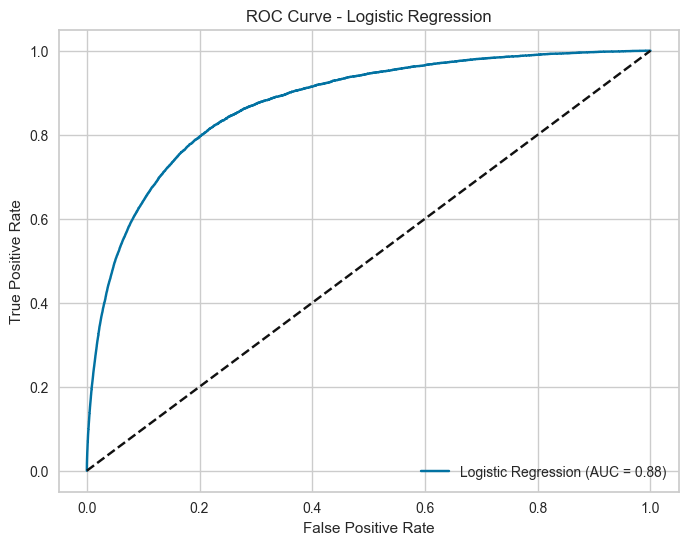

['/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/lr_model.joblib']

In [15]:
# Train Logistic Regression model
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(X, y)

# Predict probabilities for the entire dataset
lr_predictions = lr_model.predict_proba(X)[:, 1]

# Evaluate model performance
lr_auc = roc_auc_score(y, lr_predictions)
print("Logistic Regression AUC:", lr_auc)

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y, lr_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.2f})'.format(lr_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Saving the model
joblib.dump(lr_model, '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/lr_model.joblib')

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>XGBoost</span></b>

XGBoost AUC: 0.9595722264008697


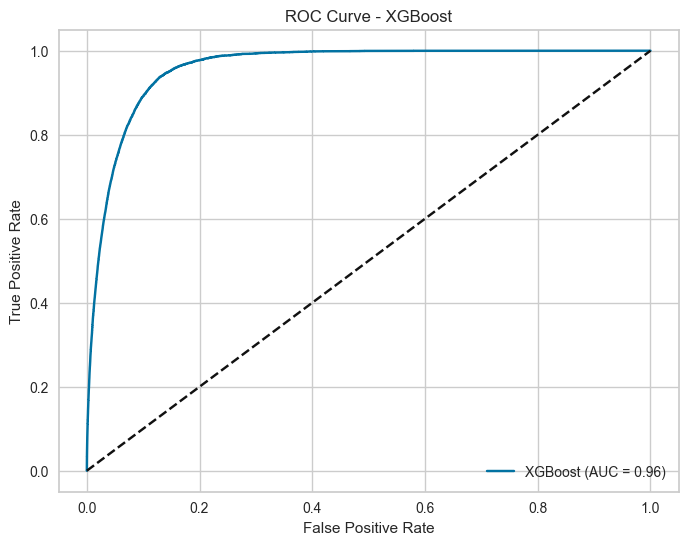

['/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/xgb_model.joblib']

In [16]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(tree_method='hist', scale_pos_weight=89.67005)
xgb_model.fit(X, y)

# Predict probabilities for the entire dataset
xgb_predictions = xgb_model.predict_proba(X)[:, 1]

# Evaluate model performance
xgb_auc = roc_auc_score(y, xgb_predictions)
print("XGBoost AUC:", xgb_auc)

# Plot ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y, xgb_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(xgb_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Saving the model
joblib.dump(xgb_model, '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/xgb_model.joblib')

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Random Forest</span></b>

Random Forest AUC: 1.0


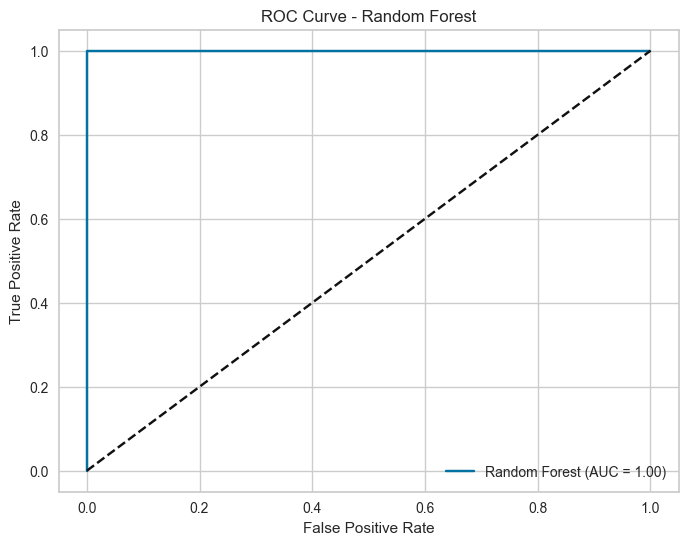

['/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/rf_model.joblib']

In [17]:
# Train Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X, y)

# Predict probabilities for the entire dataset
rf_predictions = rf_model.predict_proba(X)[:, 1]

# Evaluate model performance
rf_auc = roc_auc_score(y, rf_predictions)
print("Random Forest AUC:", rf_auc)

# Plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y, rf_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(rf_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Saving the model
joblib.dump(rf_model, '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/rf_model.joblib')

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Note:</span></b> 
After you have trained and saved the models once, you can load them from next time.

In [18]:
# Loading

# BASE
lr_model = joblib.load('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/lr_model.joblib')
xgb_model = joblib.load('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/xgb_model.joblib')
rf_model = joblib.load('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/rf_model.joblib')

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Testing:</span></b> Base

<a id="3.3"></a>
## <b><span style='color:yellow'>1st approach:</span></b> 

- Finding fraud accounts individually using each model.
- Taking the common accounts.

In [ ]:

df['predicted_fraud'] = lr_predictions

# Identify fraudulent accounts (put the threshold)
fraudulent_accounts = df[df['predicted_fraud'] > 0.5]['Account_Number']

# Save fraudulent account numbers to a .txt file (overwrite mode)
with open('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/lr_fraudulent_accounts.txt', 'w') as file:
    fraudulent_accounts.to_csv(file, index=False, header=False)

# Print number and percentage of fraudulent accounts
num_fraud_accounts = len(fraudulent_accounts)
total_accounts = len(df)
percentage_fraudulent = (num_fraud_accounts / total_accounts) * 100

print("Number of Fraudulent Accounts:", num_fraud_accounts)
print("Percentage of Fraudulent Accounts: {:.2f}%".format(percentage_fraudulent))


Number of Fraudulent Accounts: 269589
Percentage of Fraudulent Accounts: 26.96%


In [ ]:

df['predicted_fraud'] = xgb_predictions

# Identify fraudulent accounts (put the threshold)
fraudulent_accounts = df[df['predicted_fraud'] > 0.5]['Account_Number']

# Save fraudulent account numbers to a .txt file (overwrite mode)
with open('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/xgb_fraudulent_accounts.txt', 'w') as file:
    fraudulent_accounts.to_csv(file, index=False, header=False)

# Print number and percentage of fraudulent accounts
num_fraud_accounts = len(fraudulent_accounts)
total_accounts = len(df)
percentage_fraudulent = (num_fraud_accounts / total_accounts) * 100

print("Number of Fraudulent Accounts:", num_fraud_accounts)
print("Percentage of Fraudulent Accounts: {:.2f}%".format(percentage_fraudulent))


Number of Fraudulent Accounts: 169833
Percentage of Fraudulent Accounts: 16.98%


In [ ]:

df['predicted_fraud'] = rf_predictions

# Identify fraudulent accounts (put the threshold)
fraudulent_accounts = df[df['predicted_fraud'] > 0.5]['Account_Number']

# Save fraudulent account numbers to a .txt file (overwrite mode)
with open('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/rf_fraudulent_accounts.txt', 'w') as file:
    fraudulent_accounts.to_csv(file, index=False, header=False)

# Print number and percentage of fraudulent accounts
num_fraud_accounts = len(fraudulent_accounts)
total_accounts = len(df)
percentage_fraudulent = (num_fraud_accounts / total_accounts) * 100

print("Number of Fraudulent Accounts:", num_fraud_accounts)
print("Percentage of Fraudulent Accounts: {:.2f}%".format(percentage_fraudulent))


Number of Fraudulent Accounts: 11004
Percentage of Fraudulent Accounts: 1.10%


In [ ]:

# Define file paths
lr_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/lr_fraudulent_accounts.txt'
xgb_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/xgb_fraudulent_accounts.txt'
rf_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/rf_fraudulent_accounts.txt'
output_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/fraudulent_accounts.txt'

# Read account numbers from each file
with open(lr_path, 'r') as lr_file:
    lr_accounts = set(lr_file.read().splitlines())

with open(xgb_path, 'r') as xgb_file:
    xgb_accounts = set(xgb_file.read().splitlines())

with open(rf_path, 'r') as rf_file:
    rf_accounts = set(rf_file.read().splitlines())

# Find common account numbers
common_accounts = lr_accounts & xgb_accounts & rf_accounts

# Write common account numbers to the output file
with open(output_path, 'w') as output_file:
    for account in common_accounts:
        output_file.write(account + '\n')

print(f"Number of common account numbers: {len(common_accounts)}")


Number of common account numbers: 7894


<a id="3.3"></a>
## <b><span style='color:yellow'>2nd approach:</span></b> 

- Finding fraud accounts using the average of all models.

In [136]:
'''
df['predicted_fraud'] = (lr_predictions+xgb_predictions+rf_predictions)/3
'''

In [157]:
'''
# Identify fraudulent accounts (put the threshold)
fraudulent_accounts = df[df['predicted_fraud'] > 0.50]['Account_Number']

# Save fraudulent account numbers to a .txt file (overwrite mode)
with open('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/fraudulent_accounts.txt', 'w') as file:
    fraudulent_accounts.to_csv(file, index=False, header=False)

# Print number and percentage of fraudulent accounts
num_fraud_accounts = len(fraudulent_accounts)
total_accounts = len(df)
percentage_fraudulent = (num_fraud_accounts / total_accounts) * 100

print("Number of Fraudulent Accounts:", num_fraud_accounts)
print("Percentage of Fraudulent Accounts: {:.2f}%".format(percentage_fraudulent))
'''

Number of Fraudulent Accounts: 5759
Percentage of Fraudulent Accounts: 0.58%


<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Loading the actual given fraudulent accounts</span></b> 

In [138]:

# Actual Fraud Accounts

# Load the CSV file
df_base = pd.read_csv('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/Base.csv')

# Filter the rows where fraud_bool is 1
fraud_accounts = df_base[df_base['fraud_bool'] == 1]

# Get the unique account numbers with fraud_bool=1
unique_fraud_accounts = fraud_accounts['Account_Number'].unique()

# Define the output file path
output_file_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/actual_fraudulent_accounts.txt'

# Save the unique account numbers to the text file
with open(output_file_path, 'w') as f:
    for account_number in unique_fraud_accounts:
        f.write(f"{account_number}\n")


<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Comparing my fraudulent accounts and actual fraudulent accounts.</span></b> 

In [163]:
# PERCENTAGE ACCURACY IN MY MODEL

# File paths
file1_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/fraudulent_accounts.txt'
file2_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/actual_fraudulent_accounts.txt'

# Load numbers from both files
with open(file1_path, 'r') as file1:
    numbers1 = set(map(int, file1.readlines()))

with open(file2_path, 'r') as file2:
    numbers2 = set(map(int, file2.readlines()))

# Find common numbers
common_numbers = numbers1.intersection(numbers2)

# Number of common numbers
num_common = len(common_numbers)

# Total numbers in fraudulent_accounts.txt
total_numbers_in_file1 = len(numbers1)

# Percentage of common numbers
percentage_common = (num_common / total_numbers_in_file1) * 100

print("Percentage of Correctly Identified Fraudulent Accounts: {:.2f}%".format(percentage_common))

Percentage of Correctly Identified Fraudulent Accounts: 100.00%
